In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/Flax
/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/.venv/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25
jaxtyping==0.2.36
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional

jnp.set_printoptions(precision=3, suppress=True)


In [17]:
# WARNING: this code is from QSSM project and won't be updated 
def create_mnist_classification_dataset(bsz=128, root="./data"):
    print("[*] Generating MNIST Classification Dataset...")

    # Constants
    SEQ_LENGTH, N_CLASSES, IN_DIM = 784, 10, 1
    tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5),
            #transforms.Lambda(lambda x: x.view(IN_DIM, SEQ_LENGTH).t()),
        ]
    )

    train = torchvision.datasets.MNIST(
        root, train=True, download=True, transform=tf
    )
    test = torchvision.datasets.MNIST(
        root, train=False, download=True, transform=tf
    )

    def custom_collate_fn(batch):
        transposed_data = list(zip(*batch))
        labels = np.array(transposed_data[1])
        images = np.array(transposed_data[0])

        return images, labels       


    # Return data loaders, with the provided batch size
    trainloader = torch.utils.data.DataLoader(
        train, batch_size=bsz, shuffle=True, collate_fn=custom_collate_fn
    )
    testloader = torch.utils.data.DataLoader(
        test, batch_size=bsz, shuffle=False, collate_fn=custom_collate_fn
    )

    return trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM


In [18]:
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data")

[*] Generating MNIST Classification Dataset...


In [19]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)
# convert batch_y to float
# add an extra dimension to batch_x
batch_x = batch_x[..., None]
print(batch_x.shape)
print(batch_y.dtype)


(128, 1, 28, 28) (128,)
int64
(128, 1, 28, 28, 1)
int64


7

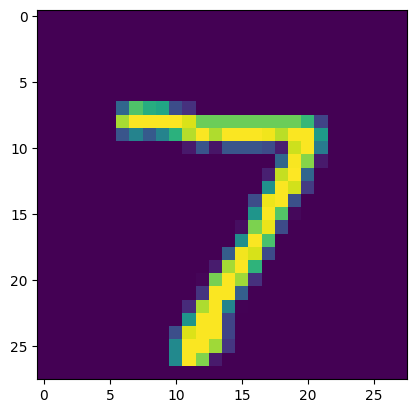

In [20]:
import matplotlib.pyplot as plt

plt.imshow(batch_x[0][0,:,:,0])
batch_y[0]

In [21]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x


In [22]:
from flax.training import train_state
import optax


def create_train_state(key, model_cls, lr):
    '''
    Create the training state for the model.
    '''
    model = model_cls()
    params = model.init(key, jnp.ones((1, 28, 28, 1)))['params']
    # use adam 
    optimizer = optax.sgd(learning_rate=lr, momentum=0.9)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [23]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-2
train_state = create_train_state(subkey, CNN, lr)
print(train_state.params.keys())


dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1'])


In [24]:
print(train_state.params['Dense_0']['kernel'].shape)
print(train_state.params['Dense_0']['bias'].shape)
# print(train_state.params['output']['kernel'].shape)
# print(train_state.params['output']['bias'].shape)

(3136, 256)
(256,)


In [25]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [29]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [30]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images[...,None], batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 100 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [31]:
for epoch in range(30):
    train_state, train_loss, train_accuracy = run_epoch(train_state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

100%|██████████| 469/469 [00:33<00:00, 14.16it/s]


Epoch 0 | Loss: 0.4293811321258545 | Accuracy: 0.8711076378822327


100%|██████████| 469/469 [00:34<00:00, 13.73it/s]


Epoch 1 | Loss: 0.08796628564596176 | Accuracy: 0.9734808206558228


100%|██████████| 469/469 [00:33<00:00, 14.10it/s]


Epoch 2 | Loss: 0.06289806216955185 | Accuracy: 0.9811378717422485


100%|██████████| 469/469 [00:33<00:00, 14.00it/s]


Epoch 3 | Loss: 0.05145036801695824 | Accuracy: 0.9844304919242859


 11%|█         | 50/469 [00:03<00:30, 13.85it/s]


KeyboardInterrupt: 